# Introduction

This notebook is for the creation of textfiles to read in satellite data from the NOAA website. It also reads in the shape files for the 92 regions of the Chesapeake Bay watershed, which can then be applied to filter the Chesapeake Bay satellite data.

# Satelitte Data


## Creating file and reading in data
Here we read in and download a satellite data using the NOAA API. The we will reformat the data to have a consistent format, only keeping variables we need to feed into the model. 

In [14]:
import re
import requests
from bs4 import BeautifulSoup


# Define the regular expression pattern
# The pattern changed March 30, 2024
pattern = re.compile(r'MODWCW_20(0[7-9]|1[0-9]|2[0-4])\d{3}_DAILY_AQUA_CHLORA_CD_1KM\.nc4')


def get_links(soup):
    links = soup.find_all('a')
    matching_links = []
    for link in links:
        if pattern.search(link.get('href', '')):
            matching_links.append(link.get('href', ''))
    return matching_links

# URL of the file to download
url = 'https://www.star.nesdis.noaa.gov/pub/socd1/ecn/data/modis/chl-swir/daily/cd/'

#soup
response = requests.get(url)
response.raise_for_status()
html_content = response.text
soup = BeautifulSoup(html_content, 'lxml')

# Get all matching links from the page with pagination handled
matching_links = get_links(soup)

# Open the output file and write the matching links
with open('../../data/MODISSchlor_filelistLONGER.txt', 'w') as outfile:
    for link in matching_links:
        outfile.write(link + '\n')

Next, we define a function to read in the nc4 files as xarrays, as suggested by NOAA.

In [2]:
import io
import xarray as xr
import logging
from tqdm import tqdm  # For progress bar
# Configure logging instead of print
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def process_nc4_from_stream(url):
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        response.raise_for_status()  # Check for request errors

        # Create an in-memory file-like object from the response content
        file_like = io.BytesIO(response.content)

        # Open the NetCDF4 file from the in-memory file-like object using xarray with netCDF4 engine
        with xr.open_dataset(file_like, decode_cf=False) as ds:
            # Print dataset information
            return ds

    except Exception as e:
        print(f'Error processing NetCDF4 file from URL: {e}')
        return None

def read_urls_from_file(file_path, base_url):
    """Reads URLs from a file and returns a list of full URLs."""
    urls = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Remove 'https:' and leading/trailing whitespace, then construct the full URL
                line = line.strip().replace('https:', '')
                full_url = f"{base_url}{line}"
                urls.append(full_url)
    except Exception as e:
        logging.error(f'Error reading URLs from file: {e}')
    return urls

def process_all_datasets(urls):
    """Process datasets from all provided URLs."""
    datasets = []

    for url in tqdm(urls, desc="Processing datasets"):
        ds = process_nc4_from_stream(url)
        if ds:
            datasets.append(ds)  # Only append if dataset was successfully processed

    return datasets

# Example usage
base_url = 'https://www.star.nesdis.noaa.gov/pub/socd1/ecn/data/modis/chl-swir/daily/cd/'  # Replace with actual base URL
file_path = '../../data/MODISSchlor_filelistLONGER.txt'  # Path to the file containing the URLs

# Read URLs from file
urls = read_urls_from_file(file_path, base_url)

# Process datasets from URLs
satellite_xarray_list = process_all_datasets(urls)

Processing datasets:  55%|█████▍    | 1512/2767 [05:23<10:17,  2.03it/s]

In [3]:
def extract_variables_from_datasets(xarray_list):
    """
    Extracts detailed information about variables, including their dimensions and data types,
    from each dataset in a list of xarray datasets.

    Parameters:
    xarray_list (list): A list of xarray.Dataset objects.

    Returns:
    list: Each entry is a dictionary representing a dataset with detailed variable information.
    """
    unique_variables = set()  # To track uniqueness
    dataset_details = []      # To hold the final details

    for ds in xarray_list:
        variable_details = {}
        coordinate_details = {}
        
        for var_name, data_array in ds.data_vars.items():
            # Create a tuple to represent the uniqueness of the variable
            unique_key = (var_name, data_array.dims, str(data_array.dtype), data_array.shape)
            if unique_key not in unique_variables:
                unique_variables.add(unique_key)
                variable_details[var_name] = {
                    'dimensions': data_array.dims,
                    'data_type': str(data_array.dtype),
                    'shape': data_array.shape
                }
        
        for var_name, data_array in ds.coords.items():
            # Create a tuple to represent the uniqueness of the variable
            unique_key = (var_name, data_array.dims, str(data_array.dtype), data_array.shape)
            if unique_key not in unique_variables:
                unique_variables.add(unique_key)
                coordinate_details[var_name] = {
                    'dimensions': data_array.dims,
                    'data_type': str(data_array.dtype),
                    'shape': data_array.shape
                }

        if variable_details or coordinate_details:  # Only add to the list if there are new, unique details
            dataset_details.append({
                'coordinate variables': coordinate_details,
                'data variables': variable_details
            })

    return dataset_details

# Example usage
# dataset_info = extract_variables_from_datasets(satellite_xarray_list)


Let's look a one dataset.

In [4]:
chlorophyll_ds = satellite_xarray_list[-1]
chlorophyll_ds

<xarray.Dataset> Size: 2MB
Dimensions:      (x: 243, y: 358, time: 1, n_vals: 2, level: 1)
Coordinates:
  * x            (x) float64 2kB -8.628e+06 -8.627e+06 ... -8.293e+06 -8.292e+06
  * y            (y) float64 3kB 4.839e+06 4.838e+06 ... 4.344e+06 4.343e+06
  * time         (time) float64 8B 1.667e+09
  * level        (level) float64 8B 0.0
Dimensions without coordinates: n_vals
Data variables:
    coord_ref    int32 4B ...
    lat          (y, x) float64 696kB ...
    lon          (y, x) float64 696kB ...
    time_bounds  (time, n_vals) float64 16B ...
    chlor_a      (time, level, y, x) float32 348kB ...
Attributes: (12/23)
    cw:polygon_longitude:           [-77.51046055 -76.75502232 -75.99958408 -...
    source:                         AQUA_MODIS
    institution:                    NOAA/NESDIS/STAR/SOCD
    history:                        [2022-10-31 11:04:01 UTC cwutils-3.7.1.12...
    dcs:createInstitution:          NOAA/NESDIS/STAR/SOCD
    dcs:createDateTime:             2022-10-31T11:04:01Z
    ...                             ...
    dcs:observedPropertyAlgorithm:  Unknown
    dcs:processingLevel:            Level 3
    cw:orbit_type:                  ascending
    cw:pass_type:                   day
    cw:polygon_latitude:            [40.00562071 40.00562071 40.00562071 40.0...
    Conventions:                    CF-1.4

In [5]:
satellite_xarray_list[0]

<xarray.Dataset> Size: 2MB
Dimensions:      (column: 243, row: 358, time: 1, n_vals: 2, level: 1)
Coordinates:
  * time         (time) float64 8B 1.409e+09
  * level        (level) float64 8B 0.0
Dimensions without coordinates: column, row, n_vals
Data variables:
    coord_ref    int32 4B ...
    x            (column) float64 2kB ...
    y            (row) float64 3kB ...
    lat          (row, column) float64 696kB ...
    lon          (row, column) float64 696kB ...
    time_bounds  (time, n_vals) float64 16B ...
    chlor_a      (time, level, row, column) float32 348kB ...
Attributes: (12/23)
    cw:polygon_longitude:           [-77.51046055 -76.75502232 -75.99958408 -...
    source:                         AQUA_MODIS
    institution:                    USDOC/NOAA/NESDIS CoastWatch
    history:                        [2017-01-28 15:17:48 EST cwf-3.3.2.253 20...
    dcs:createInstitution:          USDOC/NOAA/NESDIS CoastWatch
    dcs:createDateTime:             2017-01-28T20:17:48Z
    ...                             ...
    dcs:observedPropertyAlgorithm:  Unknown
    dcs:processingLevel:            Level 3
    cw:orbit_type:                  ascending
    cw:pass_type:                   day
    cw:polygon_latitude:            [40.00562071 40.00562071 40.00562071 40.0...
    Conventions:                    CF-1.4

In [6]:
chlorophyll_ds['chlor_a']

<xarray.DataArray 'chlor_a' (time: 1, level: 1, y: 358, x: 243)> Size: 348kB
[86994 values with dtype=float32]
Coordinates:
  * x        (x) float64 2kB -8.628e+06 -8.627e+06 ... -8.293e+06 -8.292e+06
  * y        (y) float64 3kB 4.839e+06 4.838e+06 ... 4.344e+06 4.343e+06
  * time     (time) float64 8B 1.667e+09
  * level    (level) float64 8B 0.0
Attributes:
    standard_name:  mass_concentration_of_chlorophyll_in_sea_water
    long_name:      Chlorophyll Concentration, OC3 Algorithm
    units:          mg m^-3
    coordinates:    lat lon
    cell_methods:   area: mean
    grid_mapping:   coord_ref
    source:         oc3_algorithm menghua_wang_nirswir_correction
    missing_value:  -1.0

In [7]:
print('Chlorophyll')
print(chlorophyll_ds.dims)
print(chlorophyll_ds.coords)

Chlorophyll
FrozenMappingWarningOnValuesAccess({'x': 243, 'y': 358, 'time': 1, 'n_vals': 2, 'level': 1})
Coordinates:
  * x        (x) float64 2kB -8.628e+06 -8.627e+06 ... -8.293e+06 -8.292e+06
  * y        (y) float64 3kB 4.839e+06 4.838e+06 ... 4.344e+06 4.343e+06
  * time     (time) float64 8B 1.667e+09
  * level    (level) float64 8B 0.0


In [8]:
print('Chlorophyll')
print(chlorophyll_ds.n_vals)
print(chlorophyll_ds.level)

Chlorophyll
<xarray.DataArray 'n_vals' (n_vals: 2)> Size: 16B
array([0, 1])
Dimensions without coordinates: n_vals
<xarray.DataArray 'level' (level: 1)> Size: 8B
array([0.])
Coordinates:
  * level    (level) float64 8B 0.0
Attributes:
    standard_name:  height
    units:          m
    positive:       up


Since the shape files we will use for filtering use the projected_x and projected_y coordinates `x` and `y`, let's transform all of the datasets to have the structure where `x` and `y` are coordinate variables.

In [9]:
def xarray_restructure(ds):
    if 'x' in ds.dims and 'y' in ds.dims:
        return ds
    elif 'row' in ds['lat'].dims and 'column' in ds['lat'].dims:

        # Create new DataArrays for x and y
        x_data = xr.DataArray(ds['x'].values, dims='x', coords={'x': ds['x'].values})
        y_data = xr.DataArray(ds['y'].values, dims='y', coords={'y': ds['y'].values})

        # Use existing data variables while setting dimensions
        ds_transformed = ds.assign_coords({'x': x_data, 'y': y_data})

        # Update data variable dimensions in a vectorized way
        for var_name in ds.data_vars:
            var = ds[var_name]
            if 'row' in var.dims and 'column' in var.dims:
                # Rename dimensions dynamically
                ds_transformed[var_name] = var.rename({'row': 'y', 'column': 'x'})

        return ds_transformed
    else:
        return ds

Let's try restructing the data so that latitude and longitude are coordinates and every dataset has the same structure.

In [10]:
import numpy as np
def xarray_select_variables(ds):
    # Step 1: Flatten the 2D latitude and longitude into 1D arrays.
    latitude = ds['lat'].values.flatten()
    longitude = ds['lon'].values.flatten()

    # Detect the spatial dimensions for the 'chlor_a' variable (either (row, column) or (y, x))
    if 'row' in ds['chlor_a'].dims and 'column' in ds['chlor_a'].dims:
        spatial_dims = ('row', 'column')
    elif 'y' in ds['chlor_a'].dims and 'x' in ds['chlor_a'].dims:
        spatial_dims = ('y', 'x')
    else:
        raise ValueError("Could not detect spatial dimensions for 'chlor_a'. Please check the dataset.")

    # Stack the 'chlor_a' variable based on detected spatial dimensions and get the flattened array
    var_flat = ds['chlor_a'].stack(spatial=spatial_dims).values

    # Step 3: Create a new dataset with 1D lat/lon as coordinates.
    # Remove duplicate lat/lon points to ensure unique lat/lon coordinates if needed
    lat_unique, lon_unique = np.unique(latitude), np.unique(longitude)

    # Initialize the new dataset with reshaped data
    new_ds = xr.Dataset(
        {
            'chlor_a': (('time', 'level', 'lat', 'lon'), var_flat.reshape(ds['time'].size, ds['level'].size, len(lat_unique), len(lon_unique)))
        },
        coords={
            'time': ds['time'],
            'level': ds['level'],
            'lat': lat_unique,
            'lon': lon_unique
        }
    )

    # Step 6: Dynamically copy metadata for all data variables
    for var in ds.data_vars:
        # Check if the variable exists in the new dataset and copy metadata
        if var in new_ds.data_vars:
            new_ds[var].attrs = ds[var].attrs  # Copy the metadata dynamically

    # Step 7: Dynamically copy metadata for all coordinates (no hardcoding)
    for coord in ds.coords:
        # If the coordinate exists in the new dataset, copy metadata
        if coord in new_ds.coords:
            new_ds[coord].attrs = ds[coord].attrs

    new_ds['lat'].attrs = ds['lat'].attrs  # Copy longitude metadata

    new_ds['lon'].attrs = ds['lon'].attrs  # Copy longitude metadata

    new_ds.attrs = ds.attrs

    # Check the new dataset structure
    return new_ds

In [11]:
satellite_xarray_consistent = []

for ds in tqdm(satellite_xarray_list, desc="Regridding datasets"):
    reformatted_ds = xarray_restructure(ds)
    satellite_xarray_consistent.append(reformatted_ds)

Regridding datasets: 100%|██████████| 2767/2767 [00:18<00:00, 145.63it/s]


Now we can combine the restructured datasets into one xarray.

In [12]:
import xarray as xr

def combine_xarrays(xarray_list):
    """
    Combines a list of xarray.Dataset objects into a single dataset.
    Variables with a time dimension are concatenated along that dimension,
    while variables without a time dimension are retained as is.

    Parameters:
    xarray_list (list): A list of xarray.Dataset objects to combine.

    Returns:
    xarray.Dataset: A combined xarray dataset with appropriate handling of time dimensions.
    """
    # Initialize a dictionary to hold combined variables
    combined_vars = {}
    
    # Iterate through each dataset
    for ds in tqdm(xarray_list, desc="Combining datasets"):
        for var_name, data_array in ds.data_vars.items():
            if 'time' in data_array.dims:
                # Concatenate time-dependent variables
                if var_name not in combined_vars:
                    combined_vars[var_name] = []
                combined_vars[var_name].append(data_array)
            else:
                # Retain non-time-dependent variables directly
                combined_vars[var_name] = data_array

    # Create the final dataset
    combined_dataset = xr.Dataset()

    for var_name, data in combined_vars.items():
        if isinstance(data, list):  # This variable had a time dimension
            combined_dataset[var_name] = xr.concat(data, dim='time')
        else:  # This variable does not have a time dimension
            combined_dataset[var_name] = data

    return combined_dataset

# Example usage
# combined_ds = combine_xarrays(satellite_xarray_list)

# Inspect the combined dataset
# print(combined_ds)

combined_ds = combine_xarrays(satellite_xarray_consistent)
combined_ds

Combining datasets: 100%|██████████| 2767/2767 [00:00<00:00, 13848.15it/s]


<xarray.Dataset> Size: 964MB
Dimensions:      (x: 243, y: 358, time: 2767, n_vals: 2, level: 1)
Coordinates:
  * x            (x) float64 2kB -8.628e+06 -8.627e+06 ... -8.293e+06 -8.292e+06
  * y            (y) float64 3kB 4.839e+06 4.838e+06 ... 4.344e+06 4.343e+06
  * time         (time) float64 22kB 1.409e+09 1.409e+09 ... 1.667e+09 1.667e+09
  * level        (level) float64 8B 0.0
Dimensions without coordinates: n_vals
Data variables:
    coord_ref    int32 4B ...
    lat          (y, x) float64 696kB ...
    lon          (y, x) float64 696kB ...
    time_bounds  (time, n_vals) float64 44kB 1.409e+09 1.409e+09 ... 1.667e+09
    chlor_a      (time, level, y, x) float32 963MB -1.0 -1.0 ... 0.2937 0.3537

Save the output for future use.

In [13]:
combined_ds.to_netcdf('../../data/combinedSatelitte_unmasked.nc4')

PermissionError: [Errno 13] Permission denied: '/Users/clairemerriman/Library/CloudStorage/GoogleDrive-clmerriman@davidson.edu/My Drive/ChesapeakeBay/data/combinedSatelitte_unmasked.nc4'

Check that it worked.

In [32]:
xr.open_dataset('../../data/combinedSatelitte_unmasked.nc4',decode_cf=False)

<xarray.Dataset> Size: 964MB
Dimensions:      (x: 243, y: 358, time: 2767, n_vals: 2, level: 1)
Coordinates:
  * x            (x) float64 2kB -8.628e+06 -8.627e+06 ... -8.293e+06 -8.292e+06
  * y            (y) float64 3kB 4.839e+06 4.838e+06 ... 4.344e+06 4.343e+06
  * time         (time) float64 22kB 1.409e+09 1.409e+09 ... 1.667e+09 1.667e+09
  * level        (level) float64 8B 0.0
Dimensions without coordinates: n_vals
Data variables:
    coord_ref    int32 4B ...
    lat          (y, x) float64 696kB ...
    lon          (y, x) float64 696kB ...
    time_bounds  (time, n_vals) float64 44kB ...
    chlor_a      (time, level, y, x) float32 963MB ...

## Masking datasets with shape file

We only want to work with data from the Chesapeake Bay proper. Additionally, for latitude and longitude points corresponding to land instead of water, the chlorophyll value is always set to `-1`, which will create false correlations in the analysis.

These shape firls come from the EPA and Chesapeake Bay Foundation definitions of the 92 regions of the Chesapeake Bay Watershed, accessed via [ArcGIS Hub](https://hub.arcgis.com/datasets/ChesBay::chesapeake-bay-92-segments/about).

In [12]:
pip install xarray geopandas rasterio rioxarray


Note: you may need to restart the kernel to use updated packages.


In [18]:
import geopandas as gpd

# Load shapefile
shapefile_path = '../../data/shapeFiles/Chesapeake_Bay_92_Segments.shp'
gdf = gpd.read_file(shapefile_path).drop(columns=['OBJECTID'])

# Inspect the GeoDataFrame
print(gdf.head())

  STATE     BasinGroup                  Name  CBSEG_92  \
0    DC        POTOMAC       Anacostia River  ANATF_DC   
1    MD        POTOMAC       Anacostia River  ANATF_MD   
2    VA          JAMES      Appomattox River     APPTF   
3    MD  PATAPSCO-BACK            Back River     BACOH   
4    MD       LOWER ES  Big Annemessex River     BIGMH   

                                            geometry  
0  POLYGON ((-8565111.288 4709935.421, -8565110.5...  
1  MULTIPOLYGON (((-8564979.652 4709911.163, -856...  
2  POLYGON ((-8606928.98 4482503.86, -8606922.232...  
3  POLYGON ((-8514017.911 4767829.07, -8514090.09...  
4  POLYGON ((-8434950.372 4593535.927, -8434909.6...  


Next, we will combine the shape files for the relevant regions: the Chesapeake Bay proper, which start with `CB`, Eastern Bay `EASMH`, Mobjack Bay `MOBPH`, and Tangier Sound `TANMH_MD` and `TANMH_VA`.

In [33]:
from shapely.ops import unary_union
# Define the filter
filtered_gdf = gdf[
    (gdf['CBSEG_92'].astype(str).str.startswith('CB')) |
    (gdf['CBSEG_92'] == 'EASMH') |
    (gdf['CBSEG_92'] == 'MOBPH') |
    (gdf['CBSEG_92'].astype(str).str.startswith('TANMH'))
]

combined_polygon = gpd.GeoSeries(filtered_gdf.geometry).union_all()

print(combined_polygon)

POLYGON ((-8507894.409755442 4503248.6013195515, -8507868.94049191 4503213.282092772, -8507813.761237614 4503203.062227152, -8507808.633904694 4503163.009569988, -8507879.121057276 4503147.717471801, -8507929.246079119 4503117.567678213, -8507878.30545204 4503041.558690175, -8507938.635739408 4502986.607137337, -8507863.857259272 4502920.757214531, -8507893.612750325 4502880.490855992, -8507994.653099084 4502870.104889303, -8507958.967769956 4502819.775866151, -8507979.389201079 4502789.1310693845, -8508150.04579683 4502778.947204001, -8508165.393495373 4502683.288689792, -8508210.403784376 4502653.216896713, -8508295.35512983 4502653.184796505, -8508381.109980445 4502612.695336528, -8508421.025436735 4502622.828801595, -8508446.51990043 4502693.53325557, -8508477.10489681 4502708.232949957, -8508497.435627349 4502643.147832058, -8508487.237961872 4502556.7274771705, -8508502.590560447 4502536.902849883, -8508577.319240266 4502607.170001052, -8508607.880536493 4502607.334702112, -85086

Now we can restrict the xarrays based on the combined polygon. Since the shape file uses projected coordinates instead of latitude and longitude, we need to also use the projected coordinates `x` and `y` in the xarray.

In [20]:
ds = chlorophyll_ds
ds

<xarray.Dataset> Size: 2MB
Dimensions:      (x: 243, y: 358, time: 1, n_vals: 2, level: 1)
Coordinates:
  * x            (x) float64 2kB -8.628e+06 -8.627e+06 ... -8.293e+06 -8.292e+06
  * y            (y) float64 3kB 4.839e+06 4.838e+06 ... 4.344e+06 4.343e+06
  * time         (time) float64 8B 1.667e+09
  * level        (level) float64 8B 0.0
Dimensions without coordinates: n_vals
Data variables:
    coord_ref    int32 4B ...
    lat          (y, x) float64 696kB ...
    lon          (y, x) float64 696kB ...
    time_bounds  (time, n_vals) float64 16B ...
    chlor_a      (time, level, y, x) float32 348kB ...
Attributes: (12/23)
    cw:polygon_longitude:           [-77.51046055 -76.75502232 -75.99958408 -...
    source:                         AQUA_MODIS
    institution:                    NOAA/NESDIS/STAR/SOCD
    history:                        [2022-10-31 11:04:01 UTC cwutils-3.7.1.12...
    dcs:createInstitution:          NOAA/NESDIS/STAR/SOCD
    dcs:createDateTime:             2022-10-31T11:04:01Z
    ...                             ...
    dcs:observedPropertyAlgorithm:  Unknown
    dcs:processingLevel:            Level 3
    cw:orbit_type:                  ascending
    cw:pass_type:                   day
    cw:polygon_latitude:            [40.00562071 40.00562071 40.00562071 40.0...
    Conventions:                    CF-1.4

In [21]:
from shapely.geometry import Polygon
from shapely.vectorized import contains

def polygon_mask(ds,polygon):
    # Create the x and y grid from the dataset's coordinates
    x_coords = ds['x'].values  # x-coordinates (243,)
    y_coords = ds['y'].values  # y-coordinates (358,)
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)  # Create 2D grid from 1D x and y

    # Create a mask using the polygon
    # This will return a boolean mask (True inside the polygon, False outside)
    mask_2d = contains(polygon, x_grid, y_grid)

    # Expand the 2D mask to match the full shape of the 'chlor_a' variable using xarray's broadcasting
    mask_expanded = xr.DataArray(mask_2d, dims=('y', 'x'), coords={'y': ds['y'], 'x': ds['x']})

    # Apply the mask to the entire dataset using sel()
    # Find the indices of the valid points within the mask
    valid_x = ds['x'].where(mask_expanded.any(dim='y'), drop=True)
    valid_y = ds['y'].where(mask_expanded.any(dim='x'), drop=True)

    masked_ds = ds.sel(x=valid_x,y=valid_y)
    return masked_ds

In [22]:
polygon_mask(satellite_xarray_consistent[0],combined_polygon)

IndexError: list index out of range

Now let's write a function that goes through our list of satellite data, applies `xarray_restructure` to ensure all of the data has a consistent format, then applies `polygon_mask` to restrict to the Cheasapeake Bay.

In [18]:
def process_and_restrict_xarrays(ds_list, polygon):
    satellite_xarray_consistent = []

    for ds in tqdm(ds_list, desc="Regridding and restricting datasets"):
        reformatted_ds = xarray_restructure(ds)
        restricted_ds = polygon_mask(reformatted_ds, polygon)
        satellite_xarray_consistent.append(restricted_ds)
    return satellite_xarray_consistent

In [19]:
satellite_processed_list = process_and_restrict_xarrays(satellite_xarray_list,combined_polygon)

Regridding and restricting datasets: 100%|██████████| 2767/2767 [00:57<00:00, 48.00it/s]


And now we will check the formatting of the datasets.

In [20]:
extract_variables_from_datasets(satellite_processed_list)

[{'coordinate variables': {'x': {'dimensions': ('x',),
    'data_type': 'float64',
    'shape': (66,)},
   'y': {'dimensions': ('y',), 'data_type': 'float64', 'shape': (274,)},
   'time': {'dimensions': ('time',), 'data_type': 'float64', 'shape': (1,)},
   'level': {'dimensions': ('level',), 'data_type': 'float64', 'shape': (1,)}},
  'data variables': {'coord_ref': {'dimensions': (),
    'data_type': 'int32',
    'shape': ()},
   'lat': {'dimensions': ('y', 'x'),
    'data_type': 'float64',
    'shape': (274, 66)},
   'lon': {'dimensions': ('y', 'x'),
    'data_type': 'float64',
    'shape': (274, 66)},
   'time_bounds': {'dimensions': ('time', 'n_vals'),
    'data_type': 'float64',
    'shape': (1, 2)},
   'chlor_a': {'dimensions': ('time', 'level', 'y', 'x'),
    'data_type': 'float32',
    'shape': (1, 1, 274, 66)}}}]

Since all of the datasets have the same structure and shape, we can now combine them into one xarray. The `time` dimension is the only one that varies between datasets.

Finally, we will save this xarray into a netCDF file to use in the model.

In [22]:
combined_ds.to_netcdf('../../data/combinedSatelitte.nc4')

Let's just check that worked.

In [23]:
xr.open_dataset('../../data/combinedSatelitte.nc4')

<xarray.Dataset> Size: 201MB
Dimensions:      (x: 66, y: 274, time: 2767, n_vals: 2, level: 1)
Coordinates:
  * x            (x) float64 528B -8.523e+06 -8.521e+06 ... -8.432e+06
  * y            (y) float64 2kB 4.809e+06 4.807e+06 ... 4.429e+06 4.428e+06
    lat          (y, x) float64 145kB ...
    lon          (y, x) float64 145kB ...
  * time         (time) datetime64[ns] 22kB 2014-08-28T17:55:08 ... 2022-10-3...
  * level        (level) float64 8B 0.0
Dimensions without coordinates: n_vals
Data variables:
    coord_ref    int32 4B ...
    time_bounds  (time, n_vals) datetime64[ns] 44kB ...
    chlor_a      (time, level, y, x) float32 200MB ...

## Graphing

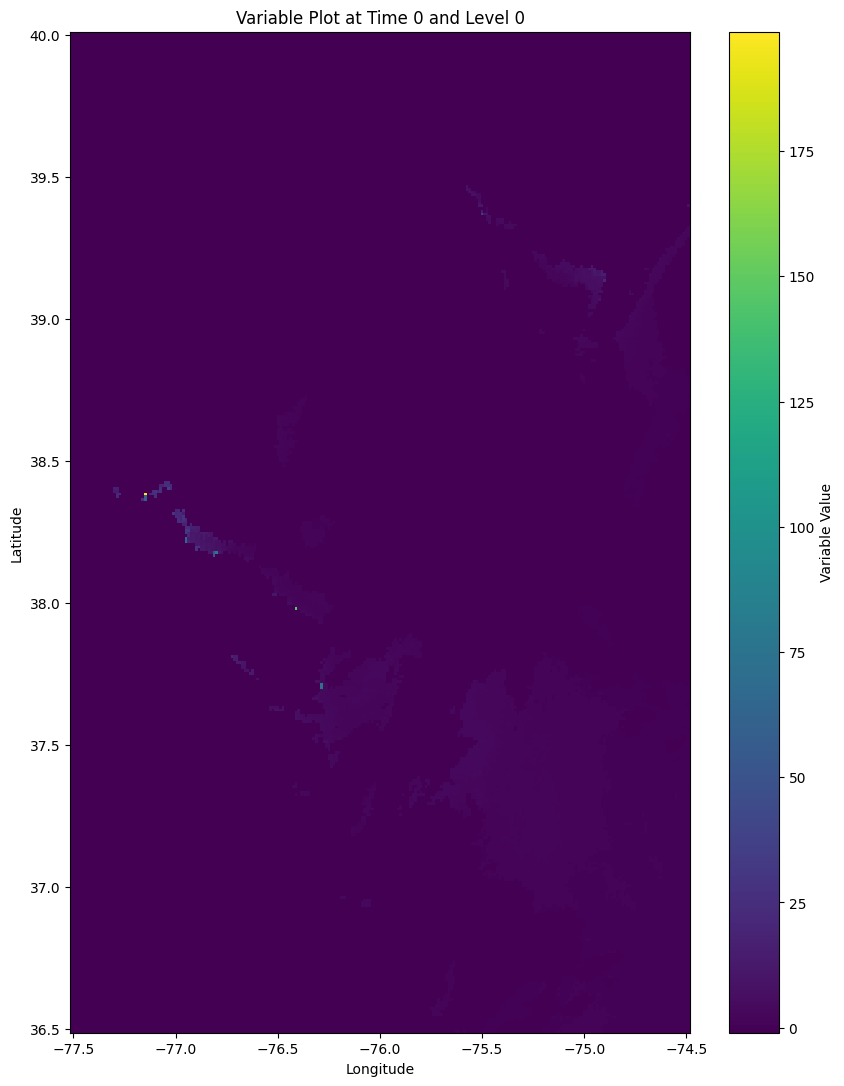

In [24]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Example data extraction
chlor_a = chlorophyll_ds['chlor_a'].values  # Shape (1, 1, 243, 358)
latitude_values = chlorophyll_ds.lat.values  # Shape (243, 358)
longitude_values = chlorophyll_ds.lon.values  # Shape (243, 358)


# Select the specific time and level
time_index = 0  # Assuming you want the first time index
level_index = 0  # Assuming you want the first level index
data_2d = chlor_a[time_index, level_index, :, :]  # Shape (243, 358)


# viridis = plt.get_cmap('viridis')
# colors = viridis(np.linspace(0, 1, 256))
# colors[0] = [0, 0, 0, 1]  # Set the color for -1 to black
# custom_cmap = mcolors.ListedColormap(colors)

# # Create a mask to handle the special case of -1
# bounds = np.linspace(0, 1, 256)
# bounds[0] = -1  # Set bound for black color
# norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)

# Plot the variable data
plt.figure(figsize=(10, 13))
plt.pcolormesh(chlorophyll_ds.lon, chlorophyll_ds.lat, chlorophyll_ds.chlor_a[0,0,:,:], shading='auto', cmap='viridis')
plt.colorbar(label='Variable Value')  # Adjust label as needed
plt.title('Variable Plot at Time {} and Level {}'.format(time_index, level_index))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()